# Model training 

In this notebook, I will train a model which classify vehicle or not.

## 1. About Dataset


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import utils


rnd_seed = 13

In [3]:
%ls data/*/

data/non-vehicles/:
Extras/ GTI/

data/vehicles/:
GTI_Far/         GTI_MiddleClose/ KITTI_extracted/
GTI_Left/        GTI_Right/


Data are classified into "non-vehicle" and "vehicle" classes. 
Each class has some subclasses. In this project, these subclasses are not necessary, so that thease subclasses are combined to "vehicle" and "non-vehicle" classes.
Before combining each class, I plot images in each class.

In [4]:
vehicle_imgs = {}
for img_dir in glob("data/vehicles/*"):
    img_type = img_dir.split("/")[-1]        
    vehicle_imgs[img_type]  = [utils.load_img(img_path) for img_path in glob(img_dir + "/*")]


In [5]:
non_vehicle_imgs = {}
for img_dir in glob("data/non-vehicles/*"):
    img_type = img_dir.split("/")[-1]        
    non_vehicle_imgs[img_type]  = [utils.load_img(img_path) for img_path in glob(img_dir + "/*")]


In [6]:
df_vehicle = pd.DataFrame([{"subclass": key, "count": len(imgs)} for key, imgs in vehicle_imgs.items()])
df_vehicle

,count,subclass
0,909,GTI_Left
1,419,GTI_MiddleClose
2,5966,KITTI_extracted
3,834,GTI_Far
4,664,GTI_Right


In [7]:
df_non_vehicle = pd.DataFrame([{"subclass": key, "count": len(imgs)} for key, imgs in non_vehicle_imgs.items()])
df_non_vehicle

,count,subclass
0,5068,Extras
1,3900,GTI


For the given data set, the numbers of two classes are almost same.

In [8]:
n_vehicle = df_vehicle["count"].sum()
n_non_vehicle = df_non_vehicle["count"].sum()

print("vehicle num: ", n_vehicle, " non-vehicle num: ", n_non_vehicle,  " ratio: ", n_vehicle / n_non_vehicle)

vehicle num:  8792  non-vehicle num:  8968  ratio:  0.980374665477


Check image shape

In [9]:
def get_test_image():
    return vehicle_imgs["GTI_Left"][274], non_vehicle_imgs["Extras"][3546]

In [10]:
img, _ = get_test_image()
img.shape

(64, 64, 3)

In [11]:
print(img.max(), img.min())

1.0 0.0470588


In [12]:
def show_image_sample(imgs, img_type, n_sample=5, seed=11, figsize=(8,2), title="", preprocessing=None):
    np.random.seed(seed)    
    choice = np.random.choice(len(imgs), n_sample, replace=False)
    plt.figure(figsize=figsize)
    plt.suptitle(title, fontsize=12)
    for i, i_img in enumerate(choice):
        img = imgs[i_img]
        if preprocessing is not None:
            img = preprocessing(img)
        ax = plt.subplot(1, n_sample, i+1)
        ax.set_title("index:{}".format(i_img))
        ax.axis('off')
        plt.imshow(img)

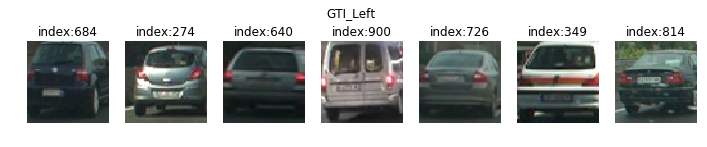

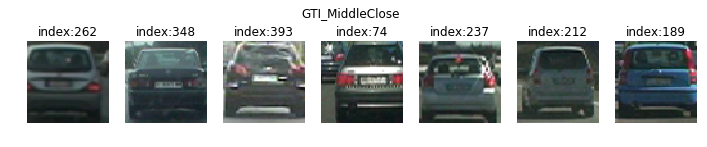

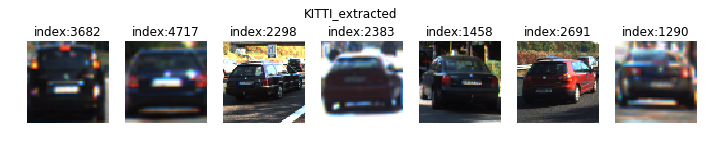

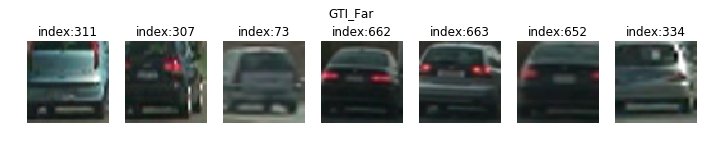

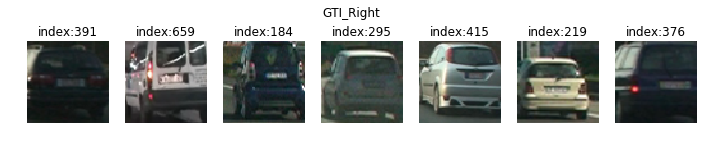

In [13]:
for key in vehicle_imgs.keys():
    show_image_sample(img_type = key, imgs = vehicle_imgs[key], title=key, figsize=(12, 2.2), n_sample=7)

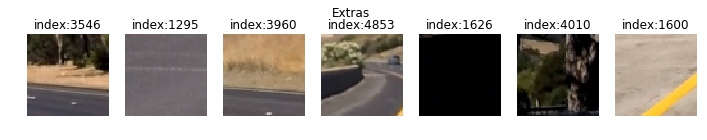

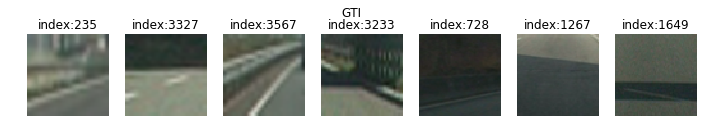

In [14]:
for key in non_vehicle_imgs.keys():
    show_image_sample(img_type = key, imgs = non_vehicle_imgs[key], title=key, figsize=(12, 2), n_sample=7)

## 2. Image augmentation

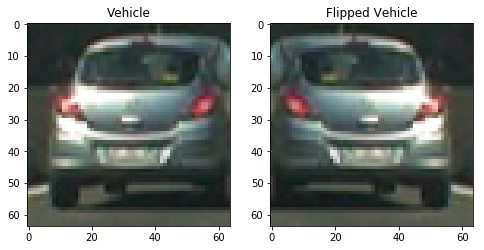

In [15]:
img1, img2 = get_test_image()
img_flip = np.flip(img1, axis=1)

plt.figure(figsize=(8, 4))
ax = plt.subplot(1, 2, 1)
ax.set_title("Vehicle")
plt.imshow(img1)

ax = plt.subplot(1, 2, 2)
ax.set_title("Flipped Vehicle")
plt.imshow(img_flip)

plt.savefig("output_images/flipped_vehicle.png", bbox_inches="tight")

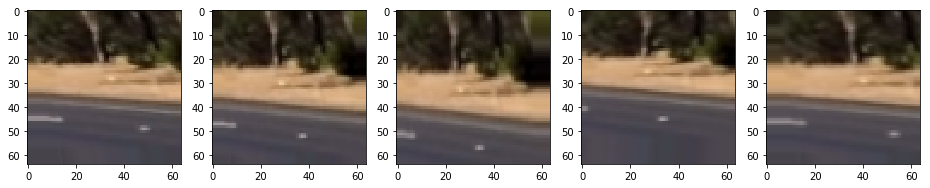

In [16]:
n = 5
np.random.seed(13)
img_augs = utils.img_augmentation(img2, n, is_vehicle=False)
plt.figure(figsize=(16, 4))
for i in range(n) :
    plt.subplot(1, n, i+1)
    plt.imshow(img_augs[i])


## 3. Feature extraction

In [17]:
import sklearn
sklearn.__version__

'0.18.dev0'

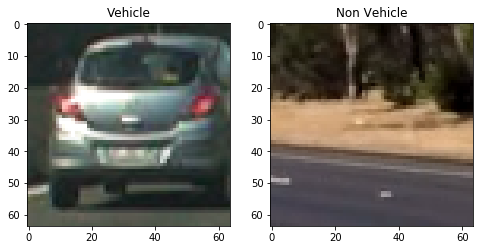

In [18]:
img_vehicle, img_non = get_test_image()


plt.figure(figsize=(8, 4))
ax = plt.subplot(1, 2, 1)
ax.set_title("Vehicle")
plt.imshow(img_vehicle)

ax = plt.subplot(1, 2, 2)
ax.set_title("Non Vehicle")
plt.imshow(img_non)

plt.savefig("output_images/raw_two_classes.png", bbox_inches="tight")

### 3.1 HOG Feature Extraction

/Users/akiyuki/.pyenv/versions/miniconda3-4.3.11/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


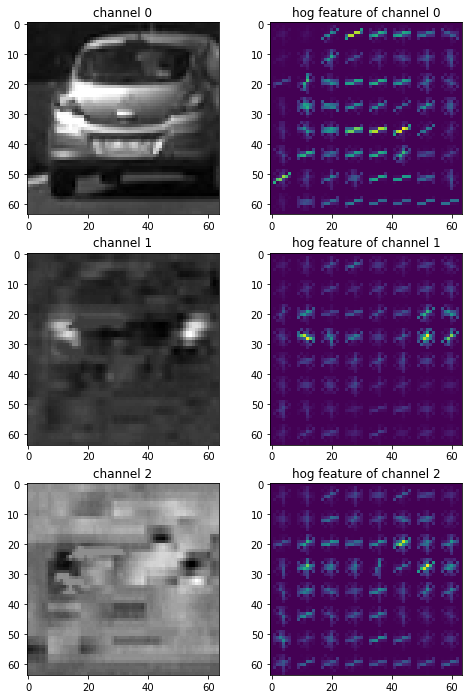

In [19]:
cspace='YCrCb'

img_cnv = utils.convert_rgb2xxx(img_vehicle, cspace=cspace)
img_hog = [None, None, None]

for i in range(3):
    _, img_hog[i] = utils.get_hog_features(img_cnv [:, :, i], orient=11, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)


plt.figure(figsize=(8, 12))

for i in range(3):

    ax=plt.subplot(3, 2, i*2 + 1)
    ax.set_title("channel {0}".format(i))
    plt.imshow(img_cnv [:, :, i], cmap='gray')
    
    ax=plt.subplot(3, 2, i*2 + 2)
    ax.set_title("hog feature of channel {0}".format(i))
    plt.imshow(img_hog[i])

plt.savefig("output_images/hog_features_vehicle.png", bbox_inches="tight")


/Users/akiyuki/.pyenv/versions/miniconda3-4.3.11/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


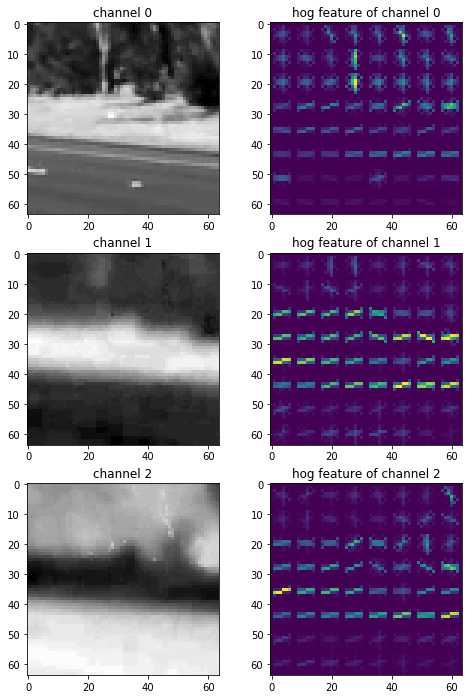

In [20]:
cspace='YCrCb'

img_cnv = utils.convert_rgb2xxx(img_non, cspace=cspace)
img_hog = [None, None, None]

for i in range(3):
    _, img_hog[i] = utils.get_hog_features(img_cnv [:, :, i], orient=11, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)


plt.figure(figsize=(8, 12))

for i in range(3):

    ax=plt.subplot(3, 2, i*2 + 1)
    ax.set_title("channel {0}".format(i))
    plt.imshow(img_cnv [:, :, i], cmap='gray')
    
    ax=plt.subplot(3, 2, i*2 + 2)
    ax.set_title("hog feature of channel {0}".format(i))
    plt.imshow(img_hog[i])

plt.savefig("output_images/hog_features_non_vehicle.png", bbox_inches="tight")

/Users/akiyuki/.pyenv/versions/miniconda3-4.3.11/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


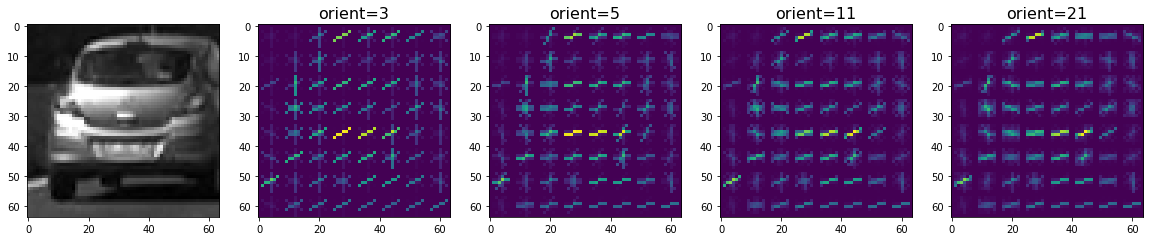

In [21]:
img_cnv = utils.convert_rgb2xxx(img_vehicle, cspace=cspace)

plt.figure(figsize=(20, 5))

orient_list = [3, 5, 11, 21]
nx = len(orient_list)
ax=plt.subplot(1, nx+1, 1)
plt.imshow(img_cnv[:, :, 0], cmap='gray')
for i, orient in enumerate(orient_list):
    _, img = utils.get_hog_features(img_cnv [:, :, 0], orient=orient, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
    ax=plt.subplot(1, nx+1, i + 2)
    ax.set_title("orient={0}".format(orient), fontsize=16)
    plt.imshow(img)

plt.savefig("output_images/hog_features_orient.png", bbox_inches="tight")

/Users/akiyuki/.pyenv/versions/miniconda3-4.3.11/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


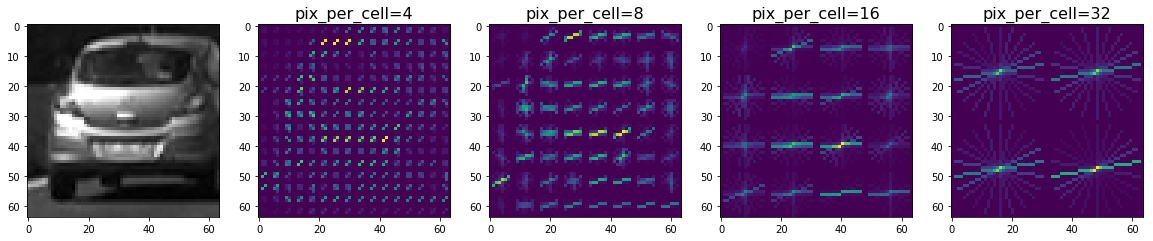

In [22]:
plt.figure(figsize=(20, 5))

ppc_list = [4, 8, 16, 32]
nx = len(ppc_list)
ax=plt.subplot(1, nx+1, 1)
plt.imshow(img_cnv[:, :, 0], cmap='gray')
for i, ppc in enumerate(ppc_list):
    _, img = utils.get_hog_features(img_cnv [:, :, 0], orient=11, pix_per_cell=ppc, cell_per_block=2, vis=True, feature_vec=False)
    ax=plt.subplot(1, nx+1, i + 2)
    ax.set_title("pix_per_cell={0}".format(ppc),  fontsize=16)
    plt.imshow(img)

plt.savefig("output_images/hog_features_ppc.png", bbox_inches="tight")

/Users/akiyuki/.pyenv/versions/miniconda3-4.3.11/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


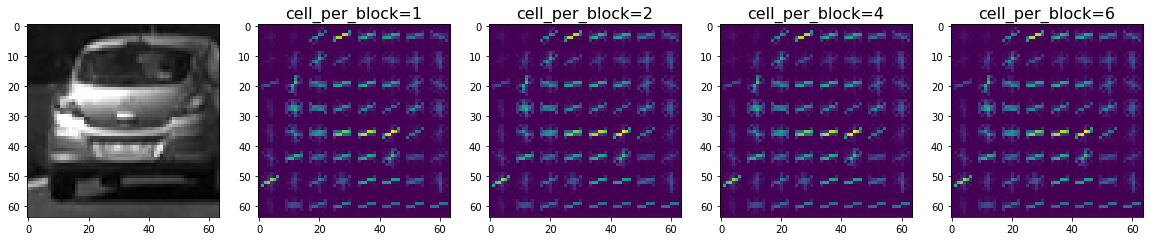

In [23]:
plt.figure(figsize=(20, 5))

cpb_list = [1, 2, 4, 6]
nx = len(cpb_list)
ax=plt.subplot(1, nx+1, 1)
plt.imshow(img_cnv[:, :, 0], cmap='gray')
for i, cpb in enumerate(cpb_list):
    _, img = utils.get_hog_features(img_cnv [:, :, 0], orient=11, pix_per_cell=8, cell_per_block=cpb, vis=True, feature_vec=False)
    ax=plt.subplot(1, nx+1, i + 2)
    ax.set_title("cell_per_block={0}".format(cpb),  fontsize=16)
    plt.imshow(img)

plt.savefig("output_images/hog_features_cpb.png", bbox_inches="tight")

### 3.2 Color Feature Extraction

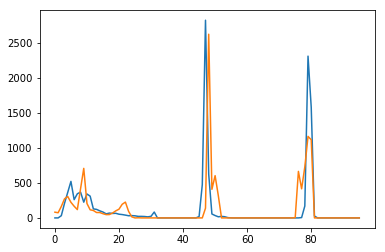

In [24]:
img_cnv = utils.convert_rgb2xxx(img_vehicle, cspace=cspace)
hist_color_vehicle = utils.color_hist(img_cnv, nbins=32, bins_range=(0, 1))

img_cnv = utils.convert_rgb2xxx(img_non, cspace=cspace)
hist_color_non_vehicle = utils.color_hist(img_cnv, nbins=32, bins_range=(0, 1))


plt.plot(hist_color_vehicle)
plt.plot(hist_color_non_vehicle)

### 3.3 Spatial Binning Feature

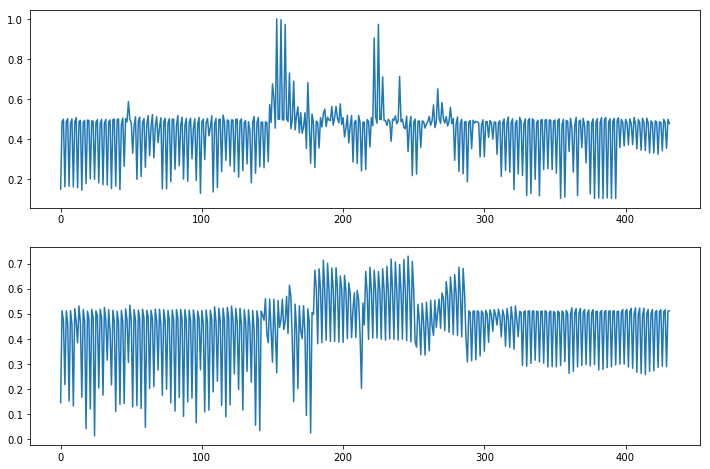

In [25]:
img_cnv = utils.convert_rgb2xxx(img_vehicle, cspace=cspace)
sb_vehicle = utils.bin_spatial(img_cnv, size=(12, 12))

img_cnv = utils.convert_rgb2xxx(img_non, cspace=cspace)
sb_non_vehicle = utils.bin_spatial(img_cnv, size=(12, 12))


plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(sb_vehicle)
plt.subplot(2, 1, 2)
plt.plot(sb_non_vehicle)

## 4 Model Training

### 4.1 Create Combined Feature

In [26]:
cspace='YCrCb'
spatial_size=(12, 12)
hist_bins=32
orient=11
pix_per_cell=8
cell_per_block=2
hog_channel='ALL'
spatial_feat=True
hist_feat=True
hog_feat=True

In [27]:
img, _ = get_test_image()
img = img_augs[3]
print(img.max(), img.min())
feats = utils.extract_image_features(img, cspace=cspace, spatial_size=spatial_size,
                                     hist_bins=hist_bins, orient=orient,                                      
                                     pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                     spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

0.924789 0.0


/Users/akiyuki/.pyenv/versions/miniconda3-4.3.11/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


### 4.2 Data Augmentation

In [28]:
%%time

feats_vehicle = []
for k, imgs in vehicle_imgs.items():

    img_augs = []
    for img in imgs:        
        img_augs.extend( [img, np.flip(img, axis=1)]) 

    print(k, " vehicle image number is ", len(img_augs))    
    for img in img_augs:
        feats = utils.extract_image_features(img, cspace=cspace, spatial_size=spatial_size,
                                             hist_bins=hist_bins, orient=orient, 
                                             pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                             spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        feats_vehicle.append(feats)

print("vehicle image is done")        

feats_non_vehicle = []
cnt = 0
for k, imgs in non_vehicle_imgs.items():

    img_augs = []
    for img in imgs:
        img_augs.extend([img] + utils.img_augmentation(img, 3, is_vehicle=False)) 
        
    print(k, " non vehicle image number is ", len(img_augs))    
    for img in img_augs:
        cnt = cnt + 1
        feats = utils.extract_image_features(img, cspace=cspace, spatial_size=spatial_size,
                                             hist_bins=hist_bins, orient=orient, 
                                             pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                             spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        feats_non_vehicle.append(feats)

X_vehicle = np.vstack(feats_vehicle)
X_non_vehicle = np.vstack(feats_non_vehicle)
X = np.vstack((X_vehicle, X_non_vehicle))

print("Training data size: ", X.shape)

GTI_Left  vehicle image number is  1818


/Users/akiyuki/.pyenv/versions/miniconda3-4.3.11/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


GTI_MiddleClose  vehicle image number is  838
KITTI_extracted  vehicle image number is  11932
GTI_Far  vehicle image number is  1668
GTI_Right  vehicle image number is  1328
vehicle image is done
Extras  non vehicle image number is  20272
GTI  non vehicle image number is  15600
Training data size:  (53456, 6996)
CPU times: user 5min 22s, sys: 5.48 s, total: 5min 28s
Wall time: 5min 50s


In [29]:
n_vehicle = X_vehicle.shape[0]
n_non_vehicle = X_non_vehicle.shape[0]
n_feature = X.shape[0]

print("The number of features is", n_feature)
print("vehicle num: ", n_vehicle, " non-vehicle num:",n_non_vehicle)

The number of features is 53456
vehicle num:  17584  non-vehicle num: 35872


### 4.3 Make labels

In [30]:
y = np.hstack((np.ones(n_vehicle), np.zeros(n_non_vehicle)))
y

array([ 1.,  1.,  1., ...,  0.,  0.,  0.])

### 4.4 Split Train and Test

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
print(X.shape, y.shape)

X_raw_train, X_raw_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = rnd_seed)

print("train: {0}\ntest: {1}".format(X_raw_train.shape[0], X_raw_test.shape[0]))

(53456, 6996) (53456,)
train: 42764
test: 10692


### 4.5 Scaling Features

Define scaler by using training data, since test data should be assumed to be unknow.

In [32]:
X_scaler = StandardScaler().fit(X_raw_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_raw_train)
X_test = X_scaler.transform(X_raw_test)

### 4.6 Train Model

In [33]:
%%time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

parameters = {'C':[0.5, 1, 5]}
svc =  LinearSVC()
clf = GridSearchCV(svc, parameters, n_jobs=3)
clf.fit(X_train, y_train)

CPU times: user 1min 10s, sys: 6.32 s, total: 1min 16s
Wall time: 3min 26s


In [34]:
clf.grid_scores_

/Users/akiyuki/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:620: DeprecationWarning: The grid_scores_ attribute is deprecated in favor of the more elaborate results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.99088, std: 0.00021, params: {'C': 0.5},
 mean: 0.99086, std: 0.00020, params: {'C': 1},
 mean: 0.99086, std: 0.00020, params: {'C': 5}]

In [35]:
clf.best_estimator_

LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

## 5. Evaluation

In [36]:
from sklearn.metrics import accuracy_score

y_pred = clf.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred)

0.9932659932659933

In [37]:
import pickle

training_info = {
    "n_feature": n_feature,
    "model": clf.best_estimator_,
    "scaler": X_scaler,
    "cspace": cspace,
    "spatial_size": spatial_size,
    "hist_bins":hist_bins,
    "orient":orient, 
    "pix_per_cell":pix_per_cell,
    "cell_per_block":cell_per_block,
    "hog_channel":hog_channel,
    "spatial_feat":spatial_feat,
    "hist_feat":hist_feat,
    "hog_feat":hog_feat
}

pickle.dump(training_info, open( "output_data/training_info.p", "wb" ) )

